In [1]:
import pandas as pd
import seaborn as sb; sb.set()
import matplotlib.pyplot as plt
import numpy as np

## Manifold over PCA
### Advantage
1. Preserve non-linear relationships in data
### Disadvantage
1. There is no good framework for handling **missing data**. In contrast, there are straightforward iterative approaches for missing data in PCA.

2. The presence of **noise** in the data can “short-circuit” the manifold and drastically change the embedding. In contrast, PCA naturally filters noise from the most important components.

3. The manifold embedding result is generally highly dependent on the number of neighbors chosen, and there is generally no **solid quantitative way to choose an optimal number of neighbors**. In contrast, PCA does not involve such a choice.

4. **Globally optimal number of output dimensions is difficult to determine**. In contrast, PCA lets you find the output dimension based on the explained variance.

5. The **meaning** of the embedded dimensions is **not always clear**. In PCA, the principal components have a very clear meaning.

6. The **computational expense** of manifold methods scales as $O[N^2]$ or $O[N^3]$. For PCA, there exist randomized approaches that are generally much faster (though see the megaman package for some more scalable implementations of manifold learning).
  
## When to Use
1. After exploring using PCA
2. For toy problems such as the S-curve below, LLE and its variants.
3. For high-dimensional data from real-world sources, LLE often produces poor results, and isometric mapping (Isomap) seems to generally lead to more meaningful embeddings.
4. For data that is highly clustered, t-distributed stochastic neighbor embedding (t-SNE) seems to work very well, though can be very slow compared to other methods.

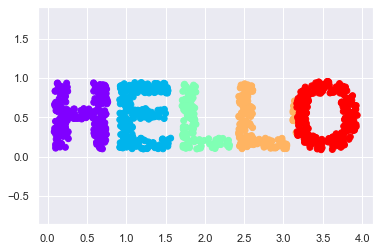

In [32]:
from matplotlib.image import imread
def make_hello(N = 1000, rseed = 42):
    f, ax = plt.subplots(figsize = (4, 1))
    f.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', ha = 'center', va = 'center', weight = 'bold', size = 85)
    f.savefig('hello.png')
    plt.close(f)
    
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]
X = make_hello(1000)
colorize = dict(c = X[:, 0], cmap = plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');

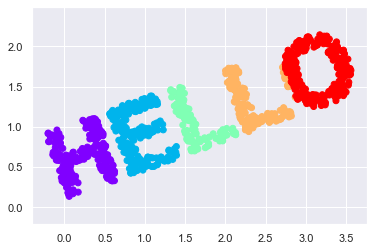

In [35]:
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
        [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)
X2 = rotate(X, 20)
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal');

(1000, 1000)


True

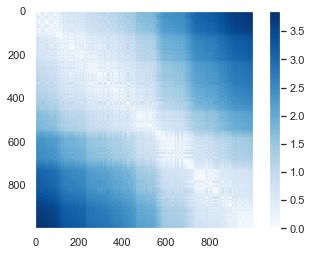

In [39]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
print(D.shape)

plt.imshow(D, zorder = 2, interpolation = 'nearest', cmap = 'Blues')
plt.colorbar()

D2 = pairwise_distances(X2)
np.allclose(D, D2)

(-1.8355134273398537,
 1.8146290838224879,
 -1.6211098048587307,
 1.6236852070855476)

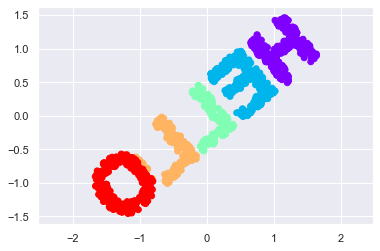

In [41]:
from sklearn.manifold import MDS
model = MDS(n_components = 2, dissimilarity = 'precomputed', random_state = 2)
out = model.fit_transform(D)
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal')

In [42]:
def random_projection(X, dimension = 3, rseed = 42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])
X3 = random_projection(X, 3)
X3.shape

(1000, 3)

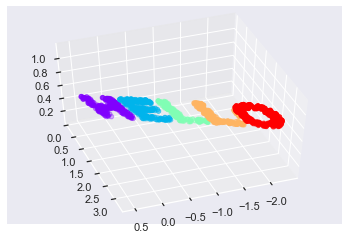

In [48]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection = '3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2], **colorize)
ax.view_init(elev = 50, azim = 70)

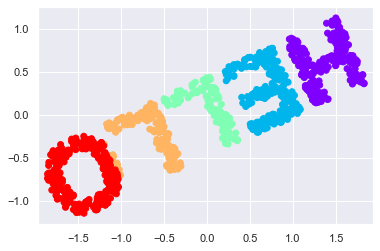

In [50]:
model = MDS(n_components = 2, random_state = 0)
out3 = model.fit_transform(X3)
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal');

In [51]:
#MDS fails in non-linear embeddings
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

XS = make_hello_s_curve(X)

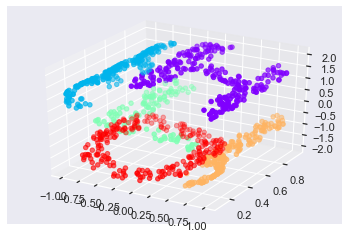

In [55]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection = '3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2], **colorize)

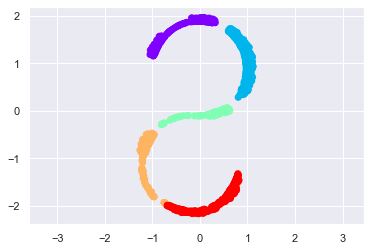

In [59]:
from sklearn.manifold import MDS
model = MDS(n_components = 2, random_state = 2)
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis('equal');

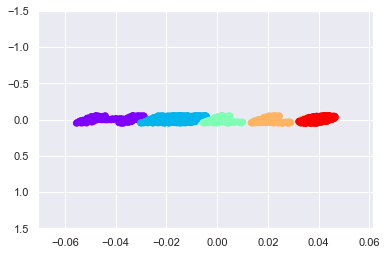

In [62]:
# Nonlinear method: Locally Linear Embedding
# Modified LLE is better at recovering well-defined manifolds with very LITTLE distortion
from sklearn.manifold import LocallyLinearEmbedding
model = LocallyLinearEmbedding(n_neighbors = 100, n_components = 2, method = 'modified', eigen_solver = 'dense')
out = model.fit_transform(XS)
f, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(1.5, -1.5);